In [1]:
%matplotlib inline
#from preamble import *
import numpy as np
import math
import pandas as pd
import pickle
import sys
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import datetime

In [22]:
fname = 'data/prediction_data.csv'
data = pd.read_csv(fname)
#data = data[(data['Season'] < 1819)]
data = data[(data['League'] != 'BUNDES') & (data['Match_Date'] < 180920)]


In [23]:
def transformResult(row):
    if(row['Result'] == 'H'):
        return 0
    elif(row['Result'] == 'A'):
        return 2
    else:
        return 1

In [24]:
from sklearn.preprocessing import MinMaxScaler

data["Result"] = data.apply(lambda row: transformResult(row),axis=1)

X_train = data[data['Season'] < 1718].reset_index(drop=True)
X_test = data[data['Season'] == 1718].reset_index(drop=True)
Nextmatch = data[data['Season'] == 1819].reset_index(drop=True)
Nextresult = Nextmatch['Result']

Y_train = X_train['Result']
Y_test = X_test['Result']
X_train = X_train.iloc[:, 9:]
X_test = X_test.iloc[:, 9:]
Nextmatch = Nextmatch.iloc[:, 9:]

In [26]:
from imblearn.over_sampling import SMOTE
X_train_, Y_train_ = SMOTE(kind='borderline2', k_neighbors=20, ratio=1).fit_sample(X_train, Y_train)
print('Number of train data {} -> {}'.format(len(X_train), len(X_train_)))
X_train, Y_train = X_train_, Y_train_
X_test = np.array(X_test)
Y_test = np.array(Y_test)

C:\Users\dlfdus\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Number of train data 7969 -> 11138


In [27]:
def Convert_to_tensor(data, XY):
    import torch
    from torch.autograd import Variable

    if XY == 'X':
        tensor_data = torch.from_numpy(data)
        tensor_data = Variable(tensor_data)
        tensor_data = tensor_data.type(torch.FloatTensor)

    elif XY == 'Y':
        tensor_data = torch.from_numpy(data)
        tensor_data = Variable(tensor_data)
        tensor_data = tensor_data.type(torch.LongTensor)

    return tensor_data

In [28]:
import torch
import torch.nn as nn


class ANN(torch.nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        node = 128
        self.relu = torch.nn.ReLU()
        self.batch = torch.nn.BatchNorm1d(node, momentum=0.01)
        self.dropout = torch.nn.Dropout(p=1 - 0.9)

        self.input_layer = torch.nn.Linear(44, node, bias=True)
        self.linear = torch.nn.Linear(node, node, bias=True)

        self.hidden_layer = torch.nn.Sequential(self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.relu,
                                                self.linear, self.batch, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.dropout, self.relu,
                                                self.linear, self.batch, self.relu
                                                )

        self.output_layer = torch.nn.Linear(node, 3, bias=True)

        torch.nn.init.kaiming_uniform_(self.input_layer.weight)
        torch.nn.init.kaiming_uniform_(self.linear.weight)

        torch.nn.init.kaiming_uniform_(self.output_layer.weight)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)

        return out

In [29]:
def Accuracy(model, X, Y):

    prediction = model(X)
    prediction = torch.nn.functional.softmax(prediction)
    correct_prediction = (torch.max(prediction.data, 1)[1] == Y.data)
    accuracy = correct_prediction.float().mean()

    return accuracy.item()

In [11]:
def Evaluation(net, X_train1, y_train1, X_test1, y_test1):

    X_train_ = Convert_to_tensor(X_train1, 'X')
    Y_train_ = Convert_to_tensor(y_train1, 'Y')
   
    accuracy = Accuracy(net, X_train_ , Y_train_)
    print('')
    print('-'*60)
    print('Train Accuracy:', accuracy)

    X_test_ = Convert_to_tensor(X_test1, 'X')
    Y_test_ = Convert_to_tensor(y_test1, 'Y')
    
    accuracy = Accuracy(net, X_test_ , Y_test_)
    print('Test Accuracy:', accuracy)

    single_prediction = net(X_test_)
    X_predict = torch.max(single_prediction.data, 1)[1]
    Y_predict = Y_test_.data

    X_predict_ = [int(i) for i in X_predict]
    Y_predict_ = [int(i) for i in Y_predict]

    match = []
    
    from sklearn.metrics import confusion_matrix
    predicted = confusion_matrix(X_predict_, Y_predict_)

    print('-'*60)
    print(classification_report(X_predict_, Y_predict, target_names=['WIN', 'DRAW', 'LOSE']))
    print('-'*60)
    nw, nd, nl = Y_predict_.count(0), Y_predict_.count(1), Y_predict_.count(2),
    print('Number of data : {}  W: {} /D: {} /L: {}'.format(len(Y_predict_), nw, nd, nl))
    print('-'*60)
    print('Confusion Matrix')
    print(predicted)
    print('-'*60)

In [151]:
now = datetime.datetime.now()
now = now.strftime('%Y%m%d%H%M%S')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = ANN()
net = net.to(device)

training_epochs = 150
batch_size = 200

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
total_step = len(X_train)

X2 = Convert_to_tensor(X_train, 'X')
Y2 = Convert_to_tensor(Y_train, 'Y')
X2, Y2 = X2.to(device), Y2.to(device)
acclist = []
costlist = []
for epoch in range(training_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    avg_cost = 0
    total_batch = len(X_train) // batch_size

    for i in range(total_batch):
        batch_xs1, batch_ys1 = X_train[i * batch_size:i * batch_size + batch_size], Y_train[
                                                                                     i * batch_size:i * batch_size + batch_size]
        X1 = Convert_to_tensor(batch_xs1, 'X')
        Y1 = Convert_to_tensor(batch_ys1, 'Y')
        X1, Y1 = X1.to(device), Y1.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs1 = net(X1)

        cost = criterion(outputs1, Y1)

        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    
    accuracy = Accuracy(net, X2, Y2)
    sys.stdout.write('\r[Epoch: {:>4}] cost = {:>.9} Acc = {:>.7}'.format(epoch + 1, avg_cost.item(), accuracy))
    acclist.append(float(accuracy))
    costlist.append(float(avg_cost.item()))
    #print("[Epoch: {:>4}] cost = {:>.9} Acc = {:>.7}".format(epoch + 1, avg_cost.data[0], accuracy))
    if epoch % 25 == 0:
        torch.save(net.state_dict(), 'data/model/{}.pth'.format(now))
print('\n\nLearning Finished!')


device = torch.device("cpu")
net = net.to(device)
Evaluation(net, X_train, Y_train, X_test, Y_test, CNN=False)

save_query_count = 0


datasave = input('Do you want to save the model? \n (Y/N)')

if datasave == 'Y' or datasave =='y':
    fname = input('Please enter your file name')
    torch.save(net.state_dict(), 'data/model/{}.pth'.format(fname))
    
elif datasave == 'N' or datasave =='n':
    pass

C:\Users\dlfdus\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch:  150] cost = 1.038131 Acc = 0.4645358

Learning Finished!

------------------------------------------------------------
Train Accuracy: 0.46193212270736694
Test Accuracy: 0.5508772134780884
------------------------------------------------------------
             precision    recall  f1-score   support

        WIN       0.70      0.62      0.66       584
       DRAW       0.31      0.32      0.32       259
       LOSE       0.47      0.57      0.51       297

avg / total       0.55      0.54      0.54      1140

------------------------------------------------------------
Number of data : 1140  W: 516 /D: 268 /L: 356
------------------------------------------------------------
Confusion Matrix
[[361 117 106]
 [ 93  84  82]
 [ 62  67 168]]
------------------------------------------------------------
Do you want to save the model? 
 (Y/N)Y
Please enter your file nameDNN(0.54)


Text(0.5,1,'Accuracy flow')

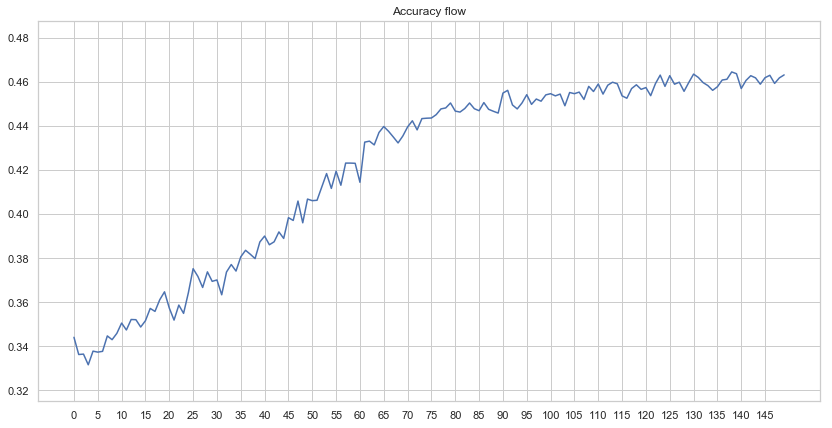

In [16]:
import seaborn as sns

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(1,1,1)
#plt.ylim(0,1)
plt.ylim(min(acclist) - min(acclist) * 0.05, max(acclist) + max(acclist) * 0.05)
ax.plot(range(0,len(acclist)),acclist);
ax.set_xticks(range(0,training_epochs, 5));
ax.set_title("Accuracy flow")

Text(0.5,1,'Cost flow')

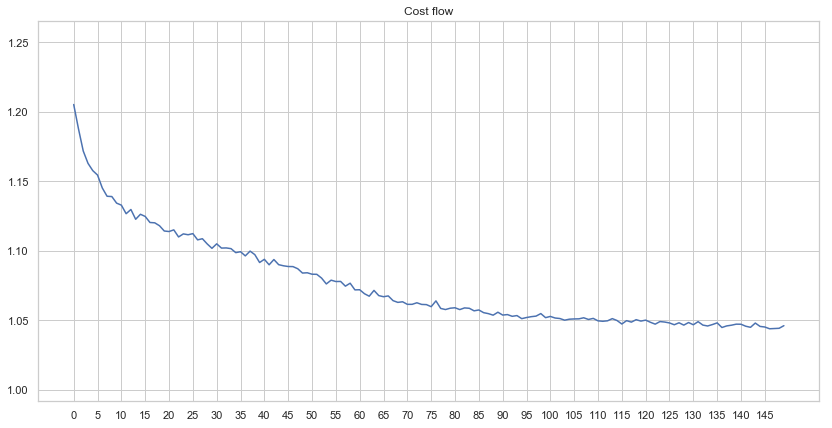

In [17]:
sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(1,1,1)
#plt.ylim(0,2)
plt.ylim(min(costlist) - min(costlist) * 0.05, max(costlist) + max(costlist) * 0.05)
ax.plot(range(0,len(costlist)),costlist);
ax.set_xticks(range(0,training_epochs, 5));
ax.set_title("Cost flow")

In [146]:
def extract_predic_score(x_data):
    single_prediction = net(x_data)
    single_prediction.data
    return single_prediction.data

In [69]:
def getaccu(row):
    if(row['Result'] == row['Predict']):
        return 'O'
    else:
        return 'X'

In [149]:
def Kprediction(x_data, loop = 1000):
    prediction = net(x_data)
    holder = torch.zeros(prediction.data.size())
    for i in range(loop):
        holder += extract_predic_score(x_data)
        sys.stdout.write('\r{} / {}'.format(i+1, loop))
    print('\n')
    holder = holder / loop

    X_predict = torch.max(holder, 1)[1]
    prob = torch.nn.functional.softmax(holder)
    return X_predict, prob

In [152]:
def transformResult2(row, feature):
    if(row[feature] == 0):
        return 'H'
    elif(row[feature] == 2):
        return 'A'
    else:
        return 'D'

In [70]:
#net.load_state_dict(torch.load('data/model/{}.pth'.format('DNN(0.54)')))

In [71]:
X_test_ = Convert_to_tensor(X_test, 'X')

In [163]:
prediction, _ = Kprediction(X_test_, 1000)

10000 / 10000



C:\Users\dlfdus\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [164]:
predictiondata = data[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name', 'Result']][data['Season'] == 1718].reset_index(drop=True)
predictiondata['Predict'] = prediction
Match_ = predictiondata.apply(lambda row: getaccu(row), axis=1)
predictiondata['Match?'] = Match_
predictiondata = predictiondata[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name', 'Predict', 'Result', 'Match?']]
predictiondata["Predict"] = predictiondata.apply(lambda row: transformResult2(row, 'Predict'),axis=1)
predictiondata["Result"] = predictiondata.apply(lambda row: transformResult2(row, 'Result'),axis=1)
predictiondata.tail()

,League,Season,Match_Date,Home_Name,Away_Name,Predict,Result,Match?
1135,SERIE,1718,180520,Udinese,Bologna,H,H,O
1136,SERIE,1718,180520,Napoli,Crotone,H,H,O
1137,SERIE,1718,180520,AC Milan,Fiorentina,H,H,O
1138,SERIE,1718,180520,Lazio,Inter,A,A,O
1139,SERIE,1718,180520,Sassuolo,Roma,A,A,O


In [165]:
OX = Counter(predictiondata['Match?'])['O']
print('Accuracy : {}'.format(OX/predictiondata.shape[0]))

Accuracy : 0.543859649122807


In [160]:
predictiondata.iloc[:50][predictiondata['League']=='LALIGA']

C:\Users\dlfdus\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,League,Season,Match_Date,Home_Name,Away_Name,Predict,Result,Match?
0,LALIGA,1718,170818,Leganes,Alaves,H,H,O
1,LALIGA,1718,170818,Valencia,Las Palmas,D,H,X
2,LALIGA,1718,170819,Celta Vigo,Real Sociedad,D,A,X
3,LALIGA,1718,170819,Girona,Atletico Madrid,A,D,X
4,LALIGA,1718,170819,Sevilla,Espanyol,H,D,X
5,LALIGA,1718,170820,Athletic Bilbao,Getafe,H,D,X
6,LALIGA,1718,170820,Barcelona,Real Betis,H,H,O
7,LALIGA,1718,170820,Deportivo La Coruna,Real Madrid,A,A,O
8,LALIGA,1718,170821,Levante,Villarreal,D,H,X
9,LALIGA,1718,170821,Malaga,Eibar,H,A,X


In [156]:
Counter(predictiondata['Match?'][predictiondata['League']=='LALIGA'])

Counter({'O': 181, 'X': 199})

In [157]:
Counter(predictiondata['Match?'][predictiondata['League']=='EPL'])

Counter({'O': 210, 'X': 170})

In [158]:
Counter(predictiondata['Match?'][predictiondata['League']=='SERIE'])

Counter({'O': 230, 'X': 150})

In [103]:
Nextmatch = np.array(Nextmatch)
Nextmatch = Convert_to_tensor(Nextmatch, 'X')

In [121]:
nextprediction, next_ = Kprediction(Nextmatch, 1000)

10000 / 10000



C:\Users\dlfdus\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [140]:
Nextmatchdata = data[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name', 'Result']][(data['Season'] == 1819) & (data['Match_Date'] < 180920) & (data['League'] != 'BUNDES')].reset_index(drop=True)
Nextmatchdata['Predict'] = nextprediction
Match_ = Nextmatchdata.apply(lambda row: getaccu(row), axis=1)
Nextmatchdata['Match?'] = Match_
Nextmatchdata = Nextmatchdata[['League', 'Season', 'Match_Date', 'Home_Name', 'Away_Name', 'Predict', 'Result', 'Match?']]
Nextmatchdata["Predict"] = Nextmatchdata.apply(lambda row: transformResult2(row, 'Predict'),axis=1)
Nextmatchdata["Result"] = Nextmatchdata.apply(lambda row: transformResult2(row, 'Result'),axis=1)
Nextmatchdata.tail()

,League,Season,Match_Date,Home_Name,Away_Name,Predict,Result,Match?
123,LALIGA,1819,180916,Leganes,Villarreal,A,A,O
124,LALIGA,1819,180916,Espanyol,Levante,H,H,O
125,LALIGA,1819,180916,Valladolid,Alaves,D,A,X
126,LALIGA,1819,180916,Sevilla,Getafe,H,A,X
127,LALIGA,1819,180917,Girona,Celta Vigo,H,H,O


In [141]:
OX = Counter(Nextmatchdata['Match?'])['O']
print('Accuracy : {}'.format(OX/Nextmatchdata.shape[0]))

Accuracy : 0.5625


In [142]:
Counter(Nextmatchdata['Match?'][Nextmatchdata['League']=='LALIGA'])

Counter({'O': 17, 'X': 22})

In [143]:
Counter(Nextmatchdata['Match?'][Nextmatchdata['League']=='EPL'])

Counter({'O': 31, 'X': 19})

In [144]:
Counter(Nextmatchdata['Match?'][Nextmatchdata['League']=='SERIE'])

Counter({'O': 24, 'X': 15})

In [145]:
Nextmatchdata[Nextmatchdata['League']=='EPL']

,League,Season,Match_Date,Home_Name,Away_Name,Predict,Result,Match?
0,EPL,1819,180810,Manchester United,Leicester,H,H,O
1,EPL,1819,180811,Newcastle United,Tottenham,A,A,O
2,EPL,1819,180811,Watford,Brighton,A,H,X
3,EPL,1819,180811,Bournemouth,Cardiff,H,H,O
4,EPL,1819,180811,Fulham,Crystal Palace,H,A,X
5,EPL,1819,180811,Huddersfield,Chelsea,A,A,O
6,EPL,1819,180811,Wolverhampton Wanderers,Everton,H,D,X
7,EPL,1819,180812,Southampton,Burnley,D,D,O
8,EPL,1819,180812,Liverpool,West Ham,H,H,O
9,EPL,1819,180812,Arsenal,Manchester City,A,A,O


In [127]:
Nextmatchdata.to_csv('data/next_prediction.csv')